<h1>Seoul Bike Trip Duration Prediction</h1>
<h3>Rubin Carkaxhia - Big Data Analytics Project</h3>

<p>The implementation of this project involves using data-mining techniques to predict the trip duration of rental bikes in Seoul Bike sharing system using the pyspark library, following some ML algorithms and methods presented in the following <a href="https://www.researchgate.net/publication/340978677_Seoul_Bike_Trip_Duration_Prediction_using_Data_Mining_Techniques">paper</a>.<br>Moreover, besides Random Forest and Linear Regression, i decided to use also different ML models compared to the paper, such as: GBT, Decision Tree Regressor and Generalized Linear Regressor.
<br>The prediction is carried out with the combination of Seoul Bike data and weather data provided by the authors and downloaded through <a href = "https://www.kaggle.com/datasets/saurabhshahane/seoul-bike-trip-duration-prediction"> Kaggle</a>.</p>

<h3>Imports</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import RFormula
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, GeneralizedLinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, lit, when,count,isnan, mean
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

<h3>Instantiating a Spark Session</h3>

In [2]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

24/01/25 20:16:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
spark

<h3>Reading the data</h3>

In [3]:
data = spark.read.format("csv")\
.option("header", "True")\
.option("inferSchema", "True")\
.option("path","Spark/Data/seoul_data.csv").load()

<h1>Data Exploration</h1>

In [5]:
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
data.show(10)

+---+--------+--------+-----------------+----------+---------+------------------+------------------+------+----+-----+----+------+------+----+-----+----+------+----+------+----+-----+-----+----+----------+----+
|_c0|Duration|Distance|            PLong|     PLatd|    DLong|             DLatd|         Haversine|Pmonth|Pday|Phour|Pmin|PDweek|Dmonth|Dday|Dhour|Dmin|DDweek|Temp|Precip|Wind|Humid|Solar|Snow|GroundTemp|Dust|
+---+--------+--------+-----------------+----------+---------+------------------+------------------+------+----+-----+----+------+------+----+-----+----+------+----+------+----+-----+-----+----+----------+----+
|  0|       3|      50|        37.544666|126.888359|37.544666|        126.888359|               0.0|     1|   1|    0|   0|     0|     1|   1|    0|   4|     0|-3.2|   0.0| 0.5| 40.0|  0.0| 0.0|      -2.2|25.0|
|  1|      24|    7670|        37.506199|127.003944| 37.55125|        127.035103| 5.713528999751687|     1|   1|    0|   0|     0|     1|   1|    0|  25|   

In [6]:
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- PLong: double (nullable = true)
 |-- PLatd: double (nullable = true)
 |-- DLong: double (nullable = true)
 |-- DLatd: double (nullable = true)
 |-- Haversine: double (nullable = true)
 |-- Pmonth: integer (nullable = true)
 |-- Pday: integer (nullable = true)
 |-- Phour: integer (nullable = true)
 |-- Pmin: integer (nullable = true)
 |-- PDweek: integer (nullable = true)
 |-- Dmonth: integer (nullable = true)
 |-- Dday: integer (nullable = true)
 |-- Dhour: integer (nullable = true)
 |-- Dmin: integer (nullable = true)
 |-- DDweek: integer (nullable = true)
 |-- Temp: double (nullable = true)
 |-- Precip: double (nullable = true)
 |-- Wind: double (nullable = true)
 |-- Humid: double (nullable = true)
 |-- Solar: double (nullable = true)
 |-- Snow: double (nullable = true)
 |-- GroundTemp: double (nullable = true)
 |-- Dust: double (nullable = true)



The column '<b>_c0</b>' represents the index, while the other 25 columns represent:

       1.  Duration:   trip duration
       2.  Distance:   trip distance
       3.  PLong:      pickup longitude
       4.  PLatd:      pickup latitude
       5.  DLong:      dropoff longitude
       6.  DLatd:      dropoff latitude
       7.  Haversine:  haversine distance function calculate longitude and latitude
       8.  Pmonth:     pickup month
       9.  Pday:       pickup day
       10. Phour:      pickup hour
       11. Pmin:       pickup minute
       12. PDweek:     pickup day of the week
       13. Dmonth:     dropoff month
       14. Dday:       dropoff day
       15. Dhour:      dropoff hour
       16. Dmin:       dropoff minute
       17. DDweek:     dropoff day of the week
       18. Temp:       temperature
       19. Precip:     precipitation
       20. Wind:       windspeed
       21. Humid:      humidity
       22. Solar:      solar radiation
       23. Snow:       snow fall
       24. GroundTemp: ground temperature
       25. Dust:       1 hour average fine dust concentration
        

In [17]:
#print number of rows and columns 
print((data.count(), len(data.columns)))

(9601139, 26)


<h1>Data Preprocessing</h1>

<h5>Let's check if there are any missing values.</h5>

In [21]:
data.select([count(when(col(c).isNull(),c)).alias(c) for c in data.columns]).show()

+---+--------+--------+-----+-----+-----+-----+---------+------+----+-----+----+------+------+----+-----+----+------+----+------+----+-----+-----+----+----------+----+
|_c0|Duration|Distance|PLong|PLatd|DLong|DLatd|Haversine|Pmonth|Pday|Phour|Pmin|PDweek|Dmonth|Dday|Dhour|Dmin|DDweek|Temp|Precip|Wind|Humid|Solar|Snow|GroundTemp|Dust|
+---+--------+--------+-----+-----+-----+-----+---------+------+----+-----+----+------+------+----+-----+----+------+----+------+----+-----+-----+----+----------+----+
|  0|       0|       0|    0|    0|    0|    0|        0|     0|   0|    0|   0|     0|     0|   0|    0|   0|     0|   0|     0|   0|    0|    0|   0|         0|   0|
+---+--------+--------+-----+-----+-----+-----+---------+------+----+-----+----+------+------+----+-----+----+------+----+------+----+-----+-----+----+----------+----+



<h5>Fortunately there are no missing values.</h5>
<h5>We now check the statistics of some of the columns of the data, the columns are not randomly chosen but they are the most important features and also the features that highly influence '<u>Duration</u>', which is our target column.</h5>

In [22]:
data.describe(['Duration', 'Distance', 'Haversine', 'Phour', 'Dhour', 'Temp', 'GroundTemp']).show()

+-------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+
|summary|          Duration|         Distance|         Haversine|            Phour|            Dhour|             Temp|        GroundTemp|
+-------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+
|  count|           9601139|          9601139|           9601139|          9601139|          9601139|          9601139|           9601139|
|   mean| 25.80293723484266|3713.518717831291|1.8703147085244394|14.37800702604139|14.42619953736739|  18.562008465873|20.723762722312074|
| stddev|25.043326742325718|3956.611273744574|1.9953610998002618|6.249244033317603|6.484493448293151|9.498075064896634|12.652210594633896|
|    min|                 1|                1|               0.0|                0|                0|            -17.8|             -13.6|
|    max|               119

<h5>From the description of the columns, we can see that there are some rows in which the <u>Haversine</u> distance is 0.
<br>This suggests that both the pick-up and drop-off locations are the same, while the trip durations vary, ranging from a minimum of 1 minute to a maximum of 119 minutes.<br>We are going to check them and see if it is due to an error or if it could be because of round-trips.</h5>

In [12]:
zero_num = data.filter(col('Haversine') == 0).count()
print(zero_num)

955083


<h5>There are 955k rows in which the haversine distance is zero.
<br>Let's investigate further</h5>

In [20]:
count_haversine = data.where("Haversine == 0 and Plong <> DLong and PLatd <> DLatd").count()
print(f"Total number of rows having different Pick-Up - Drop-Off Latitude and Pick-Up - Drop-Off Longitude: {count_haversine}")

Total number of rows having different Pick-Up - Drop-Off Latitude and Pick-Up - Drop-Off Longitude: 0


<h5>This implies that bicycles might have completed round-trip journeys, circling back to the starting point after exploring different destinations.
<br>Since we lack additional information regarding round trips, we can either remove or keep them. <br>I have decided to keep them because eliminating these data points may impact the model's performance.</h5>

<h1>Exploratory data analysis - EDA</h1>

<h4>Trip duration frequency</h4>

+--------+---------+
|Duration|Frequency|
+--------+---------+
|       5|   434870|
|       6|   431674|
|       4|   415106|
|       7|   410592|
|       8|   389080|
|       9|   361878|
|       3|   343074|
|      10|   334696|
|      11|   311761|
|      12|   288257|
|      13|   264494|
|      14|   244063|
|      15|   225565|
|      16|   208355|
|       2|   204319|
|      17|   192928|
|      18|   178549|
|      19|   167064|
|      20|   155992|
|      21|   145688|
+--------+---------+
only showing top 20 rows



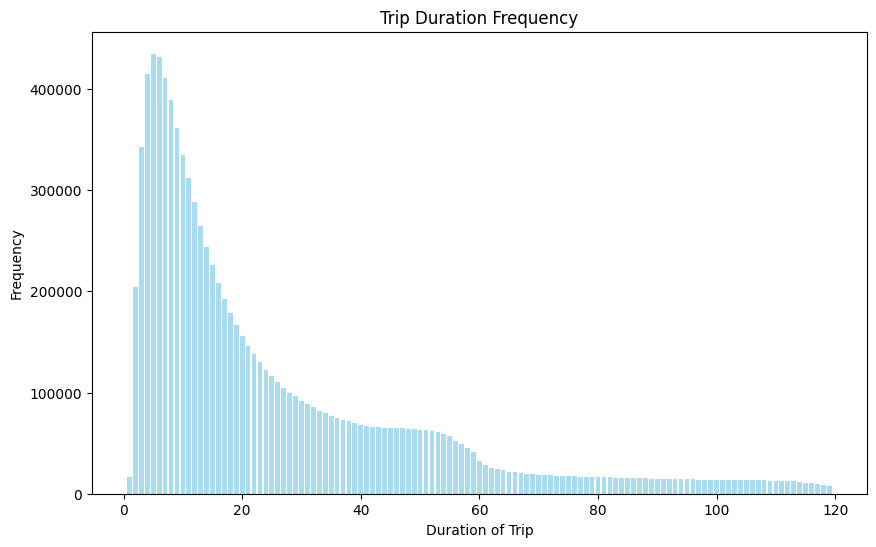

In [9]:
duration = data.groupBy("Duration").count().withColumnRenamed('count', 'Frequency')
duration_counts = duration.orderBy(col('Frequency').desc())
duration_counts.show()

duration_counts_list = duration_counts.collect()

#Extract the data for plotting
durations = [row["Duration"] for row in duration_counts_list]
frequencies = [row["Frequency"] for row in duration_counts_list]

plt.figure(figsize=(10, 6))
plt.bar(durations, frequencies, color="skyblue", alpha=0.7)
plt.title("Trip Duration Frequency")
plt.xlabel("Duration of Trip")
plt.ylabel("Frequency")
plt.show()

<h5>We can see from the graph above that the majority of the trips is between 1 and 20 minutes. </h5>

<h4>Average Duration by Month</h4>

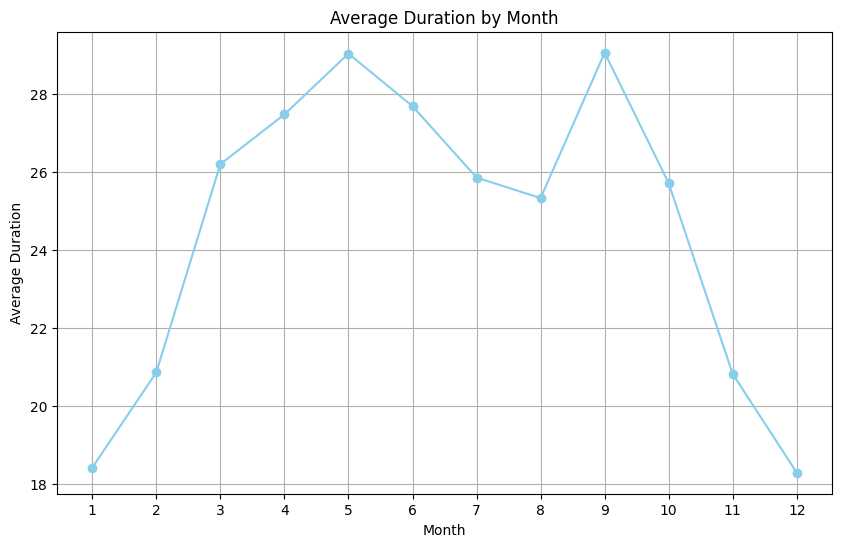

In [10]:
avg_duration_by_month = data.groupBy("Pmonth").agg(mean("Duration").alias("AvgDuration")).sort("Pmonth")
avg_duration_list = avg_duration_by_month.collect()

#Extract the data for plotting
months = [row["Pmonth"] for row in avg_duration_list]
avg_durations = [row["AvgDuration"] for row in avg_duration_list]

plt.figure(figsize=(10, 6))
plt.plot(months, avg_durations, marker='o', linestyle='-', color='skyblue')
plt.title("Average Duration by Month")
plt.xlabel("Month")
plt.ylabel("Average Duration")
plt.xticks(months)  
plt.grid(True)
plt.show()

<h5>We can clearly see that the average trip duration is way smaller during winter, it is higher from April to June and decreases again on July and August which are the hottest months. We can conclude by affirming that the temperature affects the trip duration.
<br>The average duration is higher on May and September.</h5>

<h4>Average Duration by Day of the Month</h4>

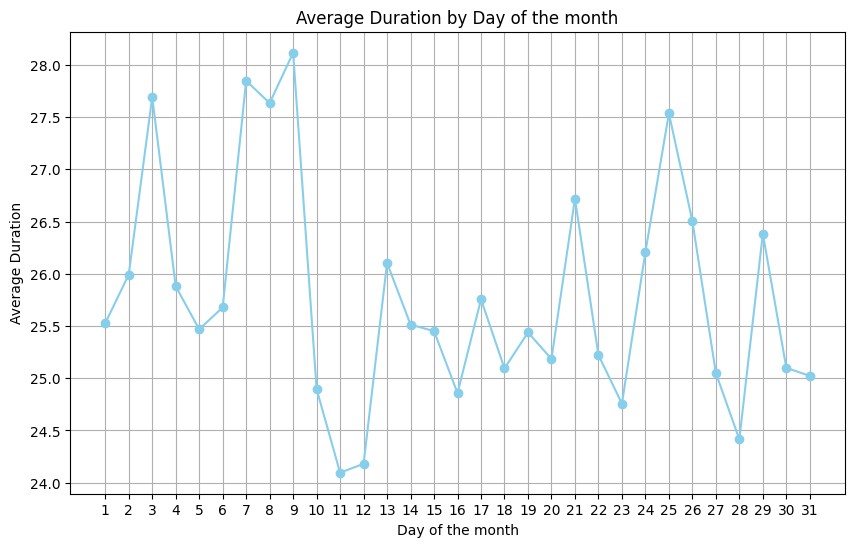

In [11]:
avg_duration_by_day = data.groupBy("Pday").agg(mean("Duration").alias("AvgDuration")).sort("Pday")
avg_duration_day_list = avg_duration_by_day.collect()

#Extract the data for plotting
days = [row["Pday"] for row in avg_duration_day_list]
avg_durations = [row["AvgDuration"] for row in avg_duration_day_list]

plt.figure(figsize=(10, 6))
plt.plot(days, avg_durations, marker='o', linestyle='-', color='skyblue')
plt.title("Average Duration by Day of the month")
plt.xlabel("Day of the month")
plt.ylabel("Average Duration")
plt.xticks(days)
plt.grid(True)
plt.show()

<h5>In this plot there is not a clear pattern across the days of the month.</h5>

<h4>Average Duration by Day of the Week</h4>

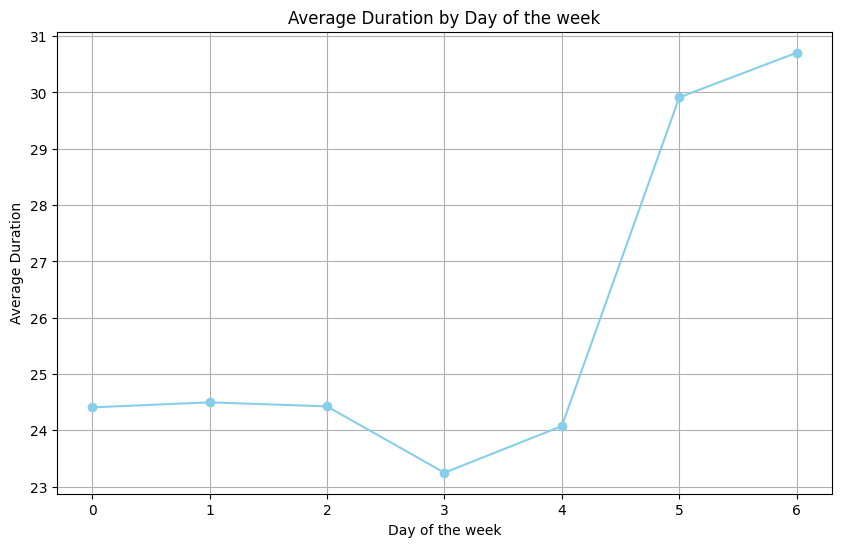

In [12]:
avg_duration_by_week = data.groupBy("PDweek").agg(mean("Duration").alias("AvgDuration")).sort("PDweek")
avg_duration_week_list = avg_duration_by_week.collect()

#Extract the data for plotting
weeks = [row["PDweek"] for row in avg_duration_week_list]
avg_durations = [row["AvgDuration"] for row in avg_duration_week_list]

plt.figure(figsize=(10, 6))
plt.plot(weeks, avg_durations, marker='o', linestyle='-', color='skyblue')
plt.title("Average Duration by Day of the week")
plt.xlabel("Day of the week")
plt.ylabel("Average Duration")
plt.xticks(weeks) 
plt.grid(True)
plt.show()

<h5>From this plot is clear instead that the average trip duration is higher during the weekends.
<br>Which makes sense because during the weekends people are more free, they go out and spend more time outside compared to weekdays.</h5>

<h4>Average Duration by Hour of the Day</h4>

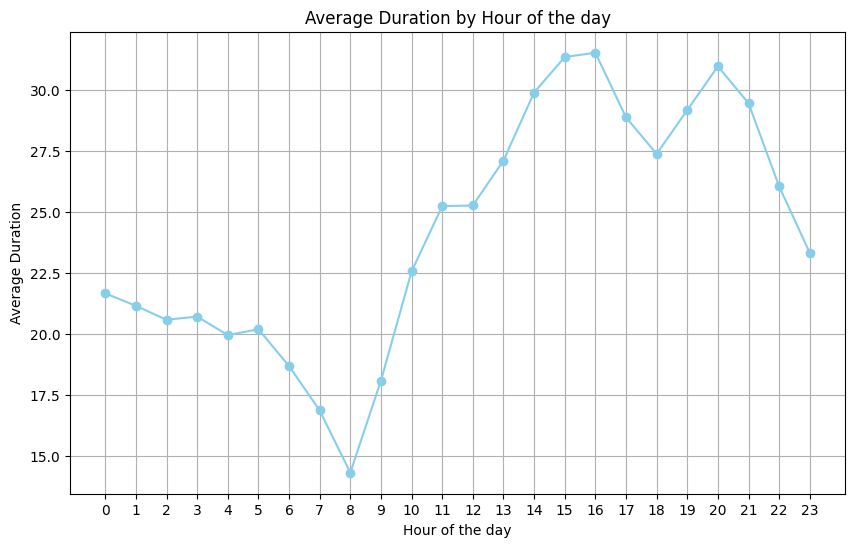

In [13]:
avg_duration_by_hour = data.groupBy("Phour").agg(mean("Duration").alias("AvgDuration")).sort("Phour")
avg_duration_hour_list = avg_duration_by_hour.collect()

# Extract the data for plotting
hours = [row["Phour"] for row in avg_duration_hour_list]
avg_durations = [row["AvgDuration"] for row in avg_duration_hour_list]

plt.figure(figsize=(10, 6))
plt.plot(hours, avg_durations, marker='o', linestyle='-', color='skyblue')
plt.title("Average Duration by Hour of the day")
plt.xlabel("Hour of the day")
plt.ylabel("Average Duration")
plt.xticks(hours) 
plt.grid(True)
plt.show()

<h5>In this case we can see that the average trip duration is higher at 15 and 16 which are hours with less traffic, and at 20 which is an evening time far from the rush hour. <br>In fact, we can spot the rush hours in the graph, and they are at 8 and 18. We can notice that the average trip duration decreases in that time span. </h5>

<h4>Number of Trips per Month</h4>

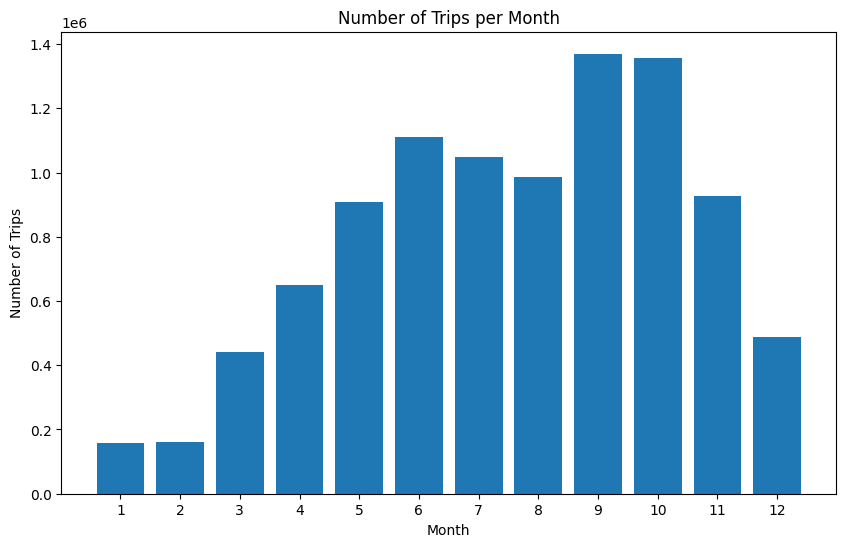

In [16]:
trips_count_month = data.groupBy("Pmonth").count().withColumnRenamed("count", "trip_count")
trips_count_list = trips_count_month.collect()

months = [row["Pmonth"] for row in trips_count_list]
trip_counts = [row["trip_count"] for row in trips_count_list]

plt.figure(figsize=(10, 6))
plt.bar(months, trip_counts)
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.xticks(months)
plt.title("Number of Trips per Month")
plt.show()

<h5>The data shows a clear trend of increased pick-ups from March to June and from August to October.</h5>

<h5>So, from the above observations we can conclude that <u>temperature</u> and <u>time</u> are influential factors for the estimation of the trip duration.</h5>

<h4>Let's plot 200 trips to see if they all occured within the Seoul's area </h4>
<h5>The reason why i chose only 200 trips is merely for better visualization</h5>

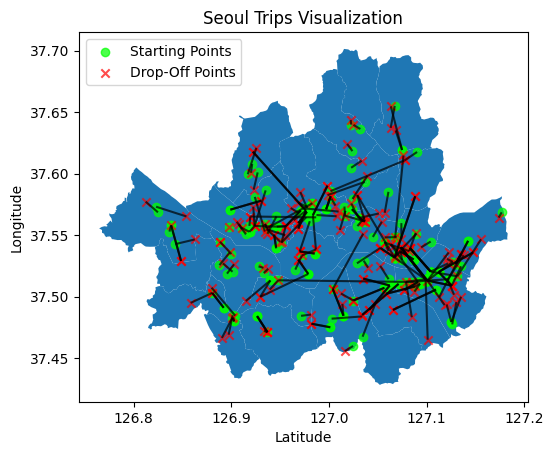

In [54]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString

seoul_map = gpd.read_file('Spark/Data/seoul_municipalities_topo_simple.json')
df_seoul = data.limit(200).toPandas()
df_seoul = df_seoul[['PLong', 'PLatd', 'DLong', 'DLatd']]

seoul_map.crs = 'epsg:4326'

geometry = [Point(xy) for xy in zip(df_seoul['PLatd'], df_seoul['PLong'])]
geometry_drop = [Point(xy) for xy in zip(df_seoul['DLatd'], df_seoul['DLong'])]

geo_df = gpd.GeoDataFrame(df_seoul, 
                          crs = seoul_map.crs, 
                          geometry = geometry)

geo_df_drop = gpd.GeoDataFrame(df_seoul, 
                          crs = seoul_map.crs, 
                          geometry = geometry_drop)


# Combine starting and drop-off points into a list of LineStrings
lines_geom = []
for i in range(len(df_seoul)):
    start_point = geo_df.loc[i, 'geometry']
    drop_point = geo_df_drop.loc[i, 'geometry']
    lines_geom.append(LineString([start_point, drop_point]))

# Create a GeoSeries of line geometries
lines = gpd.GeoSeries(lines_geom, crs=seoul_map.crs)

# Display Seoul map with points and lines
ax = seoul_map.plot()
lines.plot(ax=ax, color='black', alpha=0.7)
geo_df.plot(ax=ax, color='lime', marker='o', alpha=0.7, label='Starting Points')
geo_df_drop.plot(ax=ax, color='red', marker='x', alpha=0.7, label='Drop-Off Points')

plt.title('Seoul Trips Visualization')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(loc='upper left')
plt.show()

<h1>Feature Engineering</h1>

<h5>Let's check if the columns are all numerical or if there is a categorical column</h5>

In [15]:
cat_count = 0
num_count = 0

for col_name, data_type in data.dtypes:
    if "string" in data_type.lower():
        cat_count += 1
    elif "double" in data_type.lower() or "int" in data_type.lower():
        num_count += 1
        
print(f"There are {cat_count} categorical columns and {num_count} numerical columns")

There are 0 categorical columns and 26 numerical columns


<h5>Since there are no categorical features we don't need to convert them using the <u>stringIndexer</u></h5>

<h5>The next step is to check whether the independent variables composing the dataframe are correlated with the dependent variable, which is the one we want to predict.</h5>

In [56]:
target_column = "Duration"  

#combine all columns except the one containing the indexes into a single vector 
feature_cols = [col for col in data.columns if col != '_c0']
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_assembled = vector_assembler.transform(data)

correlation_matrix = Correlation.corr(data_assembled, "features").head()

#extract the correlation values for the target column
correlation_values = correlation_matrix[0].toArray()[:, feature_cols.index(target_column)]

correlation_dict = dict(zip(feature_cols, correlation_values))

for col, corr_value in correlation_dict.items():
    print(f"Correlation between {target_column} and {col}: {corr_value}")

Correlation between Duration and Duration: 1.0
Correlation between Duration and Distance: 0.7392326453932666
Correlation between Duration and PLong: -0.04925085174887381
Correlation between Duration and PLatd: -0.003410807626716305
Correlation between Duration and DLong: -0.04388944994065633
Correlation between Duration and DLatd: -0.003776472506346831
Correlation between Duration and Haversine: 0.3529148417188478
Correlation between Duration and Pmonth: -0.045792212213255766
Correlation between Duration and Pday: -0.009698182718510322
Correlation between Duration and Phour: 0.13339197642383618
Correlation between Duration and Pmin: -0.0038317935530647585
Correlation between Duration and PDweek: 0.08075268690365328
Correlation between Duration and Dmonth: -0.04562396422621339
Correlation between Duration and Dday: -0.009754258196752259
Correlation between Duration and Dhour: 0.14038081664047422
Correlation between Duration and Dmin: -0.012516164696096024
Correlation between Duration an

<h5>As we can see, the dependent variable Duration is correlated with almost all the other variables, despite there are several weak correlations such as <u>DLatd</u>, <u>PLatd</u>, <u>Pday</u>,etc. i decided to keep all the features in order to be more consistent with the paper, and also because the different ML models will give importance to different features, even to those who are not so greatly correlated with Duration.
<br>I am going to use all of them to train the different ML models, and then after making the predictions we are going to vizualize the most important features.
<br>We can notice that after Distance and Haversine, the features regarding the temperature and the time influence the Duration as we predicted by looking at the plots.</h5>

In [4]:
rfdata = RFormula(formula="Duration ~ .")
rf_fit_data = rfdata.fit(data)
rf_transfd_data = rf_fit_data.transform(data)

In [5]:
train_data, test_data = rf_transfd_data.randomSplit([0.8, 0.2], seed = 42)

<h5>Since the median absolute error is not available in Pyspark i decided to implement it myself.
<br>The formula of MedAE = median | $(Y_i - \hat{Y_i}) , ... , (Y_i - \hat{Y_i})$ |
<br>Where $ Y_i$ is considered the actual value, $\hat{Y_i}$ is the value predicted by the models</h5>

In [6]:
def median_absolute_error(predictions):
    
    true_predicted_values = predictions.select('Duration', 'prediction').collect()

    true_values = [row['Duration'] for row in true_predicted_values]
    predicted_values = [row['prediction'] for row in true_predicted_values]

    absolute_errors = np.abs(np.subtract(true_values, predicted_values))

    medae = np.median(absolute_errors)
    return medae

<h1>Machine Learning Model Building & Evaluation </h1>

<h3>Linear Regression</h3>

In [7]:
linear_regression = LinearRegression(featuresCol='features', labelCol='Duration')

linear_regression_model = linear_regression.fit(train_data)
linear_regression_predictions = linear_regression_model.transform(test_data)
linear_regression_predictions.select("Duration","prediction").show()

metrics=['rmse', 'r2', 'medae', 'mae']
lr_results = {}

for metric in metrics:
    if metric == "medae":
        medae_result = median_absolute_error(linear_regression_predictions)
        lr_results[metric] = medae_result
    else:
        evaluator = RegressionEvaluator(labelCol='Duration', metricName=metric)
        metric_result = evaluator.evaluate(linear_regression_predictions)
        lr_results[metric] = metric_result

for metric_name, met_result in lr_results.items():
    print(f"Linear Regression - {metric_name.capitalize()}: {met_result}")

24/01/25 20:17:44 WARN Instrumentation: [67947a17] regParam is zero, which might cause numerical instability and overfitting.
24/01/25 20:25:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/25 20:25:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/01/25 20:36:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+------------------+
|Duration|        prediction|
+--------+------------------+
|       8| 9.359384655291407|
|      25| 22.25834760153161|
|       3|   7.8583538180864|
|      30|25.184638154599654|
|      12|11.676305184420173|
|      14|13.958472989067488|
|      23|13.258426089018982|
|      85| 70.20058675083253|
|      15|16.095050687733462|
|      17|11.694072665719247|
|      32|24.649379328726738|
|      13| 12.33080197721226|
|       6|  8.32932934646253|
|      22|15.023860051310905|
|      30| 21.11265543831614|
|      25| 20.81712989699581|
|      51| 56.25691312349879|
|      61|31.078550408260455|
|      23|14.849189930018426|
|      26| 19.87081855686351|
+--------+------------------+
only showing top 20 rows



Linear Regression - Rmse: 16.451808699181477
Linear Regression - R2: 0.5685025895313959
Linear Regression - Medae: 6.908527935212035
Linear Regression - Mae: 10.117206726238345


<h5>The results obtained for the Linear Regressor are the same as those obtained by the authors of the paper.</h5>

<h3>Random Forest</h3>

In [10]:
random_forest = RandomForestRegressor(featuresCol='features', labelCol='Duration')
random_forest_model = random_forest.fit(train_data)
random_forest_predictions = random_forest_model.transform(test_data)
random_forest_predictions.select("Duration","prediction").show()

metrics=['rmse', 'r2', 'medae', 'mae']
rf_results = {}

for metric in metrics:
    if metric == "medae":
        medae_result = median_absolute_error(random_forest_predictions)
        rf_results[metric] = medae_result
    else:
        evaluator = RegressionEvaluator(labelCol='Duration', metricName=metric)
        metric_result = evaluator.evaluate(random_forest_predictions)
        rf_results[metric] = metric_result

for metric_name, met_result in rf_results.items():
    print(f"Random Forest - {metric_name.capitalize()}: {met_result}")


+--------+------------------+
|Duration|        prediction|
+--------+------------------+
|       8| 9.992970182190547|
|      25| 32.80731369312231|
|       3| 9.005195523798788|
|      30| 35.26811720546455|
|      12|11.405005450139496|
|      14|16.647023697130628|
|      23| 16.17713177781928|
|      85| 61.23407695627893|
|      15|18.980104140544743|
|      17|11.874897369450844|
|      32|30.699213161214665|
|      13| 15.60551828365862|
|       6| 9.159238759182536|
|      22|16.847577049939012|
|      30| 33.52206736457088|
|      25| 21.58207982791638|
|      51| 50.78043376797624|
|      61| 35.75515316127495|
|      23| 16.17713177781928|
|      26|18.464661639810533|
+--------+------------------+
only showing top 20 rows



Random Forest - Rmse: 15.325003527618593
Random Forest - R2: 0.6255860182505453
Random Forest - Medae: 6.247682831645202
Random Forest - Mae: 9.694364709563207


<h5>Let's check the feature importance of Random Forest</h5>

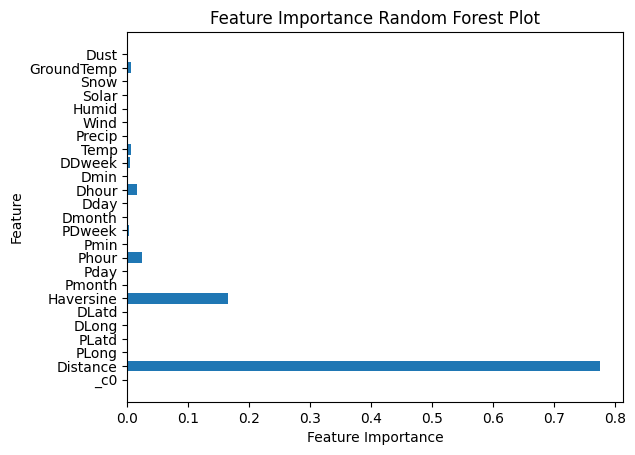

In [49]:
all_feature_names = data.columns

feature_to_exclude = "Duration"

selected_feature_names = [feature for feature in all_feature_names if feature != feature_to_exclude]

feature_importances = random_forest_model.featureImportances.toArray()
features = selected_feature_names  
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Random Forest Plot')
plt.show()


<h3>Gradient Boosted Trees</h3>

In [10]:
gradient_boosted_trees = GBTRegressor(featuresCol='features', labelCol='Duration')
gradient_boosted_trees_model = gradient_boosted_trees.fit(train_data)
gradient_boosted_trees_predictions = gradient_boosted_trees_model.transform(test_data)
gradient_boosted_trees_predictions.select("Duration","prediction").show()

metrics=['rmse', 'r2', 'medae', 'mae']
gbt_results = {}

for metric in metrics:
    if metric == "medae":
        medae_result = median_absolute_error(gradient_boosted_trees_predictions)
        gbt_results[metric] = medae_result
    else:
        evaluator = RegressionEvaluator(labelCol='Duration', metricName=metric)
        metric_result = evaluator.evaluate(gradient_boosted_trees_predictions)
        gbt_results[metric] = metric_result

for metric_name, met_result in gbt_results.items():
    print(f"GBT Regression - {metric_name.capitalize()}: {met_result}")

+--------+------------------+
|Duration|        prediction|
+--------+------------------+
|       8| 9.509539648521034|
|      25| 27.00734452959548|
|       3| 5.453404497474387|
|      30|27.373899676981857|
|      12|10.970289452968931|
|      14|15.664513760193834|
|      23|15.614020728514294|
|      85|   67.835204153086|
|      15| 22.18225064906612|
|      17|10.970289452968931|
|      32|27.351818025723002|
|      13|14.912446690505059|
|       6| 6.080762204591279|
|      22|16.456800285638018|
|      30| 26.93316754417553|
|      25| 23.94541939160023|
|      51| 57.52498181372383|
|      61|   41.677268208056|
|      23|16.252520026701244|
|      26|23.428275363686986|
+--------+------------------+
only showing top 20 rows



GBT Regression - Rmse: 12.062797111547075
GBT Regression - R2: 0.7680219258919293
GBT Regression - Medae: 3.6696574767789407
GBT Regression - Mae: 7.157173704428074


<h5>Again, we plot the feature importance</h5>

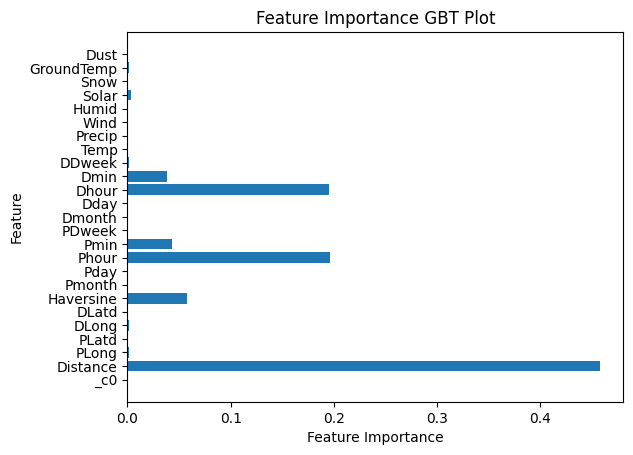

In [48]:
feature_importances = gradient_boosted_trees_model.featureImportances.toArray()
features = selected_feature_names  
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance GBT Plot')
plt.show()

<h3>Generalized Linear Regressor</h3>

In [17]:
glr = GeneralizedLinearRegression(featuresCol='features', labelCol='Duration')
glr_model = glr.fit(train_data)
glr_predictions = glr_model.transform(test_data)
glr_predictions.select("Duration","prediction").show()

metrics=['rmse', 'r2', 'medae', 'mae']
glr_results = {}

for metric in metrics:
    if metric == "medae":
        medae_result = median_absolute_error(glr_predictions)
        glr_results[metric] = medae_result
    else:
        evaluator = RegressionEvaluator(labelCol='Duration', metricName=metric)
        metric_result = evaluator.evaluate(glr_predictions)
        glr_results[metric] = metric_result

for metric_name, met_result in glr_results.items():
    print(f"GLR - {metric_name.capitalize()}: {met_result}")


24/01/20 17:25:27 WARN Instrumentation: [a75492f9] regParam is zero, which might cause numerical instability and overfitting.


+--------+------------------+
|Duration|        prediction|
+--------+------------------+
|       8| 9.359384655291407|
|      25| 22.25834760153161|
|       3|   7.8583538180864|
|      30|25.184638154599654|
|      12|11.676305184420173|
|      14|13.958472989067488|
|      23|13.258426089018982|
|      85| 70.20058675083253|
|      15|16.095050687733462|
|      17|11.694072665719247|
|      32|24.649379328726738|
|      13| 12.33080197721226|
|       6|  8.32932934646253|
|      22|15.023860051310905|
|      30| 21.11265543831614|
|      25| 20.81712989699581|
|      51| 56.25691312349879|
|      61|31.078550408260455|
|      23|14.849189930018426|
|      26| 19.87081855686351|
+--------+------------------+
only showing top 20 rows



GLR - Rmse: 16.451808699181477
GLR - R2: 0.5685025895313959
GLR - Medae: 6.908527935212035
GLR - Mae: 10.117206726238345


<h3>Decision Tree Regressor</h3>

In [20]:
dt = DecisionTreeRegressor(featuresCol="features", labelCol="Duration")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)
dt_predictions.select("Duration","prediction").show()

metrics=['rmse', 'r2', 'medae', 'mae']
dt_results = {}

for metric in metrics:
    if metric == "medae":
        medae_result = median_absolute_error(dt_predictions)
        dt_results[metric] = medae_result
    else:
        evaluator = RegressionEvaluator(labelCol='Duration', metricName=metric)
        metric_result = evaluator.evaluate(dt_predictions)
        dt_results[metric] = metric_result

for metric_name, met_result in dt_results.items():
    print(f"Decision tree Regressor - {metric_name.capitalize()}: {met_result}")


+--------+------------------+
|Duration|        prediction|
+--------+------------------+
|       8|12.203142174370699|
|      25|30.126133856337336|
|       3| 7.994762644044616|
|      30|30.126133856337336|
|      12|12.203142174370699|
|      14|17.874879064184658|
|      23|17.874879064184658|
|      85| 70.42723951991651|
|      15|25.414354829609568|
|      17|12.203142174370699|
|      32|30.126133856337336|
|      13|17.874879064184658|
|       6| 7.994762644044616|
|      22|17.874879064184658|
|      30|30.126133856337336|
|      25|25.414354829609568|
|      51| 59.05640266469282|
|      61| 45.26413807371776|
|      23|17.874879064184658|
|      26|25.414354829609568|
+--------+------------------+
only showing top 20 rows



Decision tree Regressor - Rmse: 14.505743202130144
Decision tree Regressor - R2: 0.6645476323457851
Decision tree Regressor - Medae: 4.203142174370699
Decision tree Regressor - Mae: 8.573235917386322


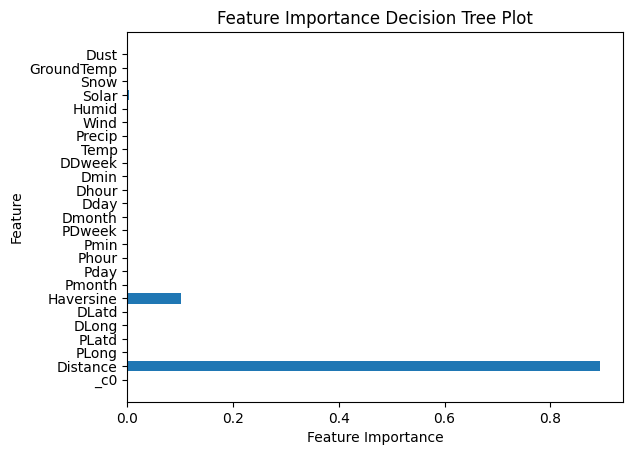

In [47]:
feature_importances = dt_model.featureImportances.toArray()
features = selected_feature_names  
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Decision Tree Plot')
plt.show()

<h3>Scatter plot of the results obtained with the different models</h3>
<h5>Since we have millions of parameters the resulting plots were almost impossible to read and interpret, so in order to have a more informative plot i used only 1000 samples.</h5>

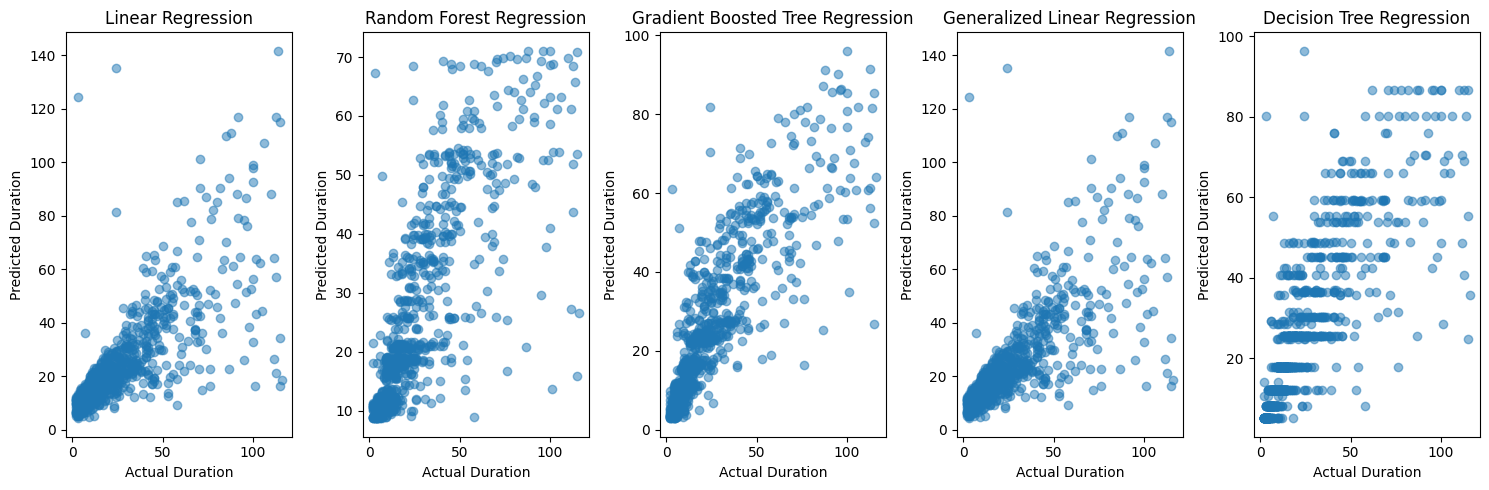

In [78]:
plt.figure(figsize=(15, 5))

# Collect data for plotting
subsampled_data = linear_regression_predictions.limit(1000)
plot_lr = subsampled_data.select("Duration", "prediction").toPandas()

subsampled_data = random_forest_predictions.limit(1000)
plot_rf = subsampled_data.select("Duration", "prediction").toPandas()

subsampled_data = gradient_boosted_trees_predictions.limit(1000)
plot_gbt = subsampled_data.select("Duration", "prediction").toPandas()

subsampled_data = glr_predictions.limit(1000)
plot_glr = subsampled_data.select("Duration", "prediction").toPandas()

subsampled_data = dt_predictions.limit(1000)
plot_dt = subsampled_data.select("Duration", "prediction").toPandas()



plt.subplot(1, 5, 1)
plt.scatter(plot_lr['Duration'], plot_lr['prediction'], alpha=0.5)
plt.xlabel('Actual Duration')
plt.ylabel('Predicted Duration')
plt.title('Linear Regression')

plt.subplot(1, 5, 2)
plt.scatter(plot_rf['Duration'], plot_rf['prediction'], alpha=0.5)
plt.xlabel('Actual Duration')
plt.ylabel('Predicted Duration')
plt.title('Random Forest Regression')

plt.subplot(1, 5, 3)
plt.scatter(plot_gbt['Duration'], plot_gbt['prediction'], alpha=0.5)
plt.xlabel('Actual Duration')
plt.ylabel('Predicted Duration')
plt.title('Gradient Boosted Tree Regression')

plt.subplot(1, 5, 4)
plt.scatter(plot_glr['Duration'], plot_glr['prediction'], alpha=0.5)
plt.xlabel('Actual Duration')
plt.ylabel('Predicted Duration')
plt.title('Generalized Linear Regression')

plt.subplot(1, 5, 5)
plt.scatter(plot_dt['Duration'], plot_dt['prediction'], alpha=0.5)
plt.xlabel('Actual Duration')
plt.ylabel('Predicted Duration')
plt.title('Decision Tree Regression')

plt.tight_layout()
plt.show()

<h5>Let's compare the metrics obtained by the five different models.</h5>

In [75]:
metrics_data = {
    'Model': ['Linear Regression', 'Random Forest Regression', 'Gradient Boosted Tree Regression', 'Generalized Linear Regression', 'Decision Tree Regressor'],
    'RMSE': [lr_results['rmse'], rf_results['rmse'], gbt_results['rmse'], glr_results['rmse'], dt_results['rmse']],
    'R2': [lr_results['r2'], rf_results['r2'], gbt_results['r2'], glr_results['r2'], dt_results['r2']],
    'MedAE': [lr_results['medae'], rf_results['medae'], gbt_results['medae'], glr_results['medae'], dt_results['medae']],
    'MAE': [lr_results['mae'], rf_results['mae'], gbt_results['mae'], glr_results['mae'], dt_results['mae']]   
}

metrics_df = pd.DataFrame(metrics_data)

metrics_df

,Model,RMSE,R2,MedAE,MAE
0,Linear Regression,16.451809,0.568503,6.908528,10.117207
1,Random Forest Regression,15.325004,0.625586,6.247683,9.694365
2,Gradient Boosted Tree Regression,12.062797,0.768022,3.669657,7.157174
3,Generalized Linear Regression,16.451809,0.568503,6.908528,10.117207
4,Decision Tree Regressor,14.505743,0.664548,4.203142,8.573236


<h5>The Gradient Boosted Tree Regressor is the best model according to our metrics, it performs better in all the considered evaluation criteria. It has the lowest RMSE, MedAE and MAE, as well as the highest R2.
<br><br>It is interesting to see that the Linear Regressor and the Generalized Linear Regressor achieve exactly the same results, this may imply that the additional complexity introduced by the generalization does not exert a substantial influence on the model's performance when compared to the standard Linear Regressor.<br> We can't tell for sure why without doing an in-depth evaluation.</h5>

<h2>Fine Tuning of RF and GBT</h2>

<h5>The RF resulted the best model in the paper but in my case it did not perform well, so let's see if fine tuning it can get us closer to the values obtained by the authors of the paper.</h5>
<h5>I have opted for the TrainValidationSplit instead of the CrossValidation because given the large amount of data it would take a huge amount of time to perform the CrossValidation.</h5>
<h5>Also, i have decided to sample the 10% of the training data and to use it for the fine tuning in order to speed up the computation. Since our data contains milions of rows, even though we use only 10% of it, it can still offer a good representation of the original data.</h5>

<h3>Random Forest Fine Tuning</h3>

In [ ]:
rf = RandomForestRegressor(featuresCol='features', labelCol='Duration', minInstancesPerNode = 2)

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [10, 15, 20])
             .build())

# Subsample data
subsampled_data = train_data.sample(fraction=0.1, seed=42)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='Duration')

# Set up TrainValidationSplit
random_search = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8) 

# Fit the model on the subsampled data
cv_model = random_search.fit(subsampled_data)
best_rf_model = cv_model.bestModel

In [8]:
# Print the best hyperparameters
print("Max Depth: ", best_rf_model.getMaxDepth())

Max Depth:  20


In [9]:
# Make predictions on the test data using the best model
best_rf_predictions = best_rf_model.transform(test_data)

best_rf_predictions.select("Duration","prediction").show()

metrics=['rmse', 'r2', 'medae', 'mae']
best_rf_results = {}

for metric in metrics:
    if metric == "medae":
        medae_result = median_absolute_error(best_rf_predictions)
        best_rf_results[metric] = medae_result
    else:
        evaluator = RegressionEvaluator(labelCol='Duration', metricName=metric)
        metric_result = evaluator.evaluate(best_rf_predictions)
        best_rf_results[metric] = metric_result

for metric_name, met_result in best_rf_results.items():
    print(f"Best Random Forest Regressor - {metric_name.capitalize()}: {met_result}")

+--------+------------------+
|Duration|        prediction|
+--------+------------------+
|       8| 7.728598632461056|
|      25| 25.02022941637696|
|       3|5.4462693497098025|
|      30|31.257492868973134|
|      12|11.542387174588253|
|      14|15.325018791605325|
|      23| 18.07412577333522|
|      85| 78.73214285714286|
|      15|20.377288489669507|
|      17|11.375608870197357|
|      32|28.546693528693527|
|      13| 14.32702740657724|
|       6| 6.846485019271253|
|      22|18.604989426650928|
|      30|26.467858812264872|
|      25| 27.71825396825397|
|      51| 63.28506410256411|
|      61| 35.27923532269088|
|      23|21.109541158854682|
|      26|31.912738095238105|
+--------+------------------+
only showing top 20 rows



Best Random Forest Regressor - Rmse: 11.305256949525155
Best Random Forest Regressor - R2: 0.7962433615530602
Best Random Forest Regressor - Medae: 3.340756582658983
Best Random Forest Regressor - Mae: 6.582069386458796


<h5>Let's compare the results with those of the previous non fine-tuned version </h5> 

In [11]:
metrics_data_rf = {
    'Model': ['Random Forest Regressor', 'Best Random Forest Regressor'],
    'RMSE': [rf_results['rmse'], best_rf_results['rmse']],
    'R2': [rf_results['r2'], best_rf_results['r2']],
    'MedAE': [rf_results['medae'], best_rf_results['medae']],
    'MAE': [rf_results['mae'], best_rf_results['mae']]   
}

metrics_df_rf = pd.DataFrame(metrics_data_rf)

metrics_df_rf

,Model,RMSE,R2,MedAE,MAE
0,Random Forest Regressor,15.325004,0.625586,6.247683,9.694365
1,Best Random Forest Regressor,11.305257,0.796243,3.340757,6.582069


<h5>As we can see, all the metrics of the Random Forest have improved after fine tuning. 
<br>Still not close to the results obtained by the authors of the paper though. 
    
<br>There are two ways to further improve the metrics :
    
             1. Fine tune more parameters, for example the number of Trees and/or increase the max depth
    
             2. Reduce the number of features considering only the most important ones
</h5>

<h4>Plot comparison</h4>

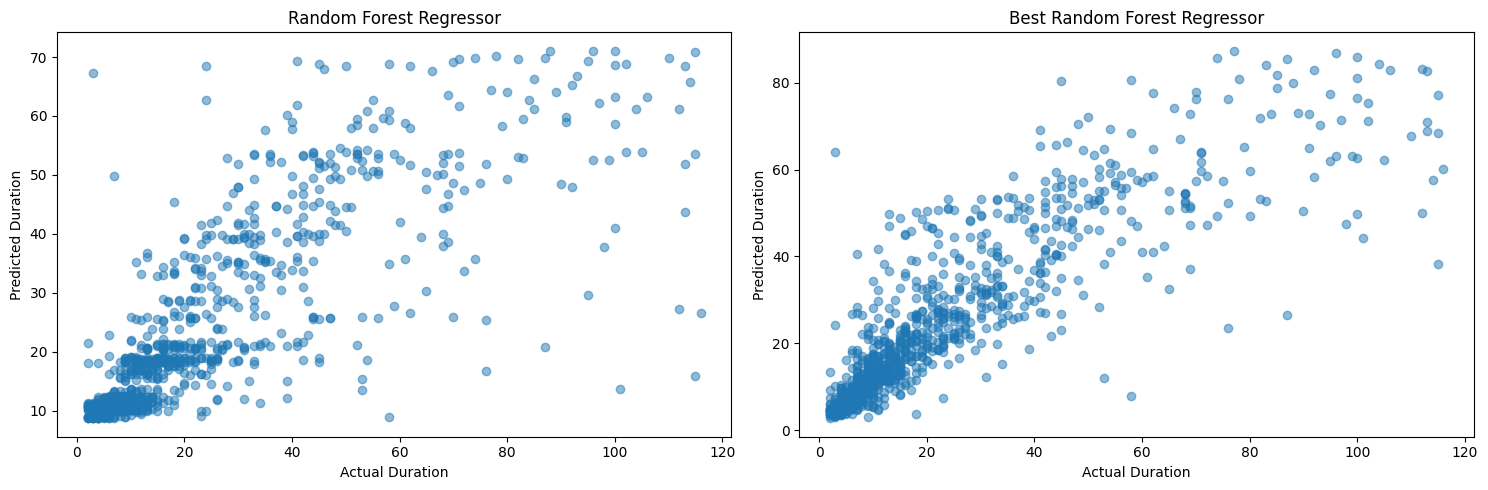

In [12]:
subsampled_rf_data = random_forest_predictions.limit(1000)
plot_rf_sub = subsampled_rf_data.select("Duration", "prediction").toPandas()

subsampled_best_rf_data = best_rf_predictions.limit(1000)
plot_best_rf = subsampled_best_rf_data.select("Duration", "prediction").toPandas()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(plot_rf_sub['Duration'], plot_rf_sub['prediction'], alpha=0.5)
plt.xlabel('Actual Duration')
plt.ylabel('Predicted Duration')
plt.title('Random Forest Regressor')

plt.subplot(1, 2, 2)
plt.scatter(plot_best_rf['Duration'], plot_best_rf['prediction'], alpha=0.5)
plt.xlabel('Actual Duration')
plt.ylabel('Predicted Duration')
plt.title('Best Random Forest Regressor')


plt.tight_layout()
plt.show()

<h3>Fine tuning the GBT </h3>
<h5>In our case the GBT was the best model and it outperformed all the others in every metric, so let's see if we can further improve its results by fine tuning some of its hyperparameters.</h5>
<h5>Again, i chose to sample and use 10% of the training data, and perform the TrainValidationSplit because it's less time consuming.</h5>

In [ ]:
gbt = GBTRegressor(featuresCol='features', labelCol='Duration')

# Define the hyperparameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 10, 15])
             .addGrid(gbt.stepSize, [0.05, 0.1, 0.2])
             .build())

subsampled_data = train_data.sample(fraction=0.1, seed=42)

# Define the evaluator
evaluator = RegressionEvaluator(metricName='rmse', labelCol='Duration')

# Set up TrainValidationSplit
tvs = TrainValidationSplit(estimator=gbt,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8) 

tvs_model = tvs.fit(subsampled_data)

# Get the best model from TrainValidationSplit
gbt_best_model = tvs_model.bestModel

In [8]:
# Print the best hyperparameters
print("Max Depth: ", gbt_best_model.getMaxDepth())
print("Step Size: ", gbt_best_model.getStepSize())

Max Depth:  10
Step Size:  0.2


In [9]:
gbt_best_predictions = gbt_best_model.transform(test_data)

gbt_best_predictions.select("Duration","prediction").show()

metrics=['rmse', 'r2', 'medae', 'mae']
gbt_best_results = {}

for metric in metrics:
    if metric == "medae":
        medae_result = median_absolute_error(gbt_best_predictions)
        gbt_best_results[metric] = medae_result
    else:
        evaluator = RegressionEvaluator(labelCol='Duration', metricName=metric)
        metric_result = evaluator.evaluate(gbt_best_predictions)
        gbt_best_results[metric] = metric_result

for metric_name, met_result in gbt_best_results.items():
    print(f"Best GBT Regressor - {metric_name.capitalize()}: {met_result}")

+--------+------------------+
|Duration|        prediction|
+--------+------------------+
|       8| 6.753495528774636|
|      25| 23.27721091350434|
|       3|3.2247814855830876|
|      30| 27.64949541393957|
|      12| 9.854660931526729|
|      14|11.693736223119812|
|      23| 22.08953587194454|
|      85| 86.68942021881682|
|      15|16.859841946574445|
|      17|13.540853819575247|
|      32|32.773729047025014|
|      13|13.189712375214505|
|       6| 5.866818421666618|
|      22|17.888046249084624|
|      30|28.230575091358233|
|      25|24.882519609022868|
|      51|  52.4129281174406|
|      61|41.133304780366394|
|      23| 24.47742810869316|
|      26|24.522157390216208|
+--------+------------------+
only showing top 20 rows



Best GBT Regressor - Rmse: 6.515156319425613
Best GBT Regressor - R2: 0.9323293150284995
Best GBT Regressor - Medae: 1.5348902531329975
Best GBT Regressor - Mae: 3.2584095102708925


In [11]:
metrics_data = {
    'Model': ['Gradient Boosted Tree Regression', 'Best Gradient Boosted Tree Regression'],
    'RMSE': [gbt_results['rmse'], gbt_best_results['rmse']],
    'R2': [gbt_results['r2'], gbt_best_results['r2']],
    'MedAE': [gbt_results['medae'], gbt_best_results['medae']],
    'MAE': [gbt_results['mae'], gbt_best_results['mae']]   
}

metrics_df = pd.DataFrame(metrics_data)

metrics_df

,Model,RMSE,R2,MedAE,MAE
0,Gradient Boosted Tree Regression,12.062797,0.768022,3.669657,7.157174
1,Best Gradient Boosted Tree Regression,6.515156,0.932329,1.534890,3.258410


<h5>The GBT metric improved quite a lot after fine tuning the hyperparameters, the R2 increased from 0.76 to 0.93, while all the other metrics decreased.<br>All the values almost reached the best values obtained in the paper.</h5>
<h5>What i can say is that, concerning this project, the GBT could be used as an effective tool to predict the trip duration. </h5>

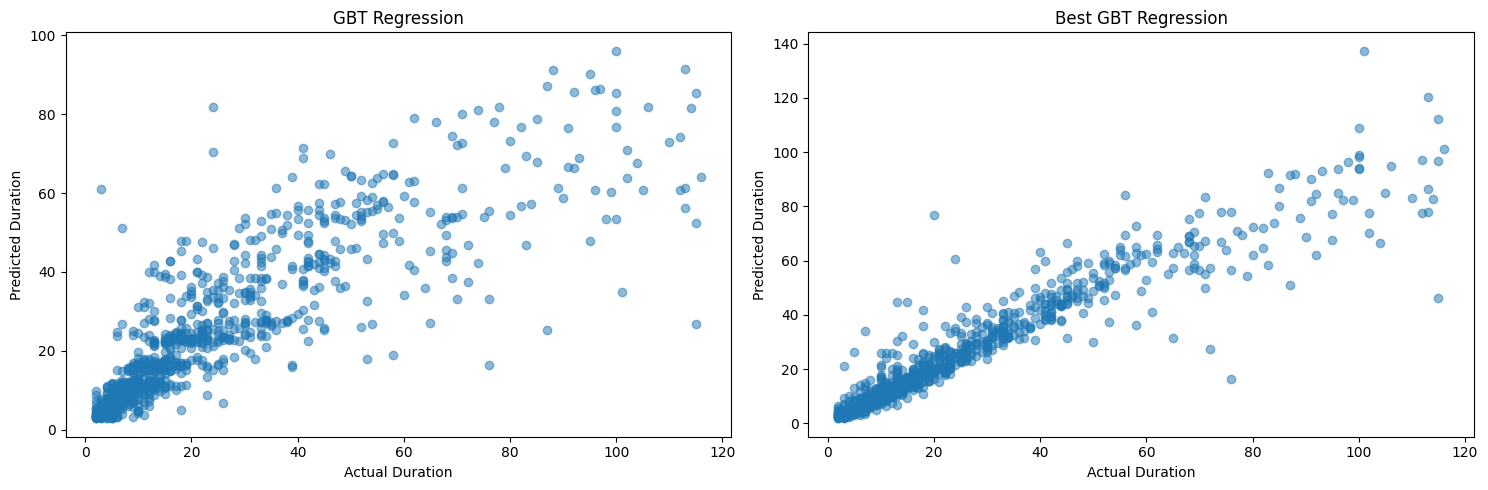

In [16]:
subsampled_gbt_data = gradient_boosted_trees_predictions.limit(1000)
plot_gbt = subsampled_gbt_data.select("Duration", "prediction").toPandas()

subsampled_best_data = gbt_best_predictions.limit(1000)
plot_best_gbt = subsampled_best_data.select("Duration", "prediction").toPandas()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(plot_gbt['Duration'], plot_gbt['prediction'], alpha=0.5)
plt.xlabel('Actual Duration')
plt.ylabel('Predicted Duration')
plt.title('GBT Regression')

plt.subplot(1, 2, 2)
plt.scatter(plot_best_gbt['Duration'], plot_best_gbt['prediction'], alpha=0.5)
plt.xlabel('Actual Duration')
plt.ylabel('Predicted Duration')
plt.title('Best GBT Regression')


plt.tight_layout()
plt.show()